In [51]:
from urllib.request import urlretrieve
from pyopenms import *
import pandas as pd
from matplotlib import pyplot as plt
searchfile = "BSA1.mzML"
searchdb = "bsa.fasta"


# Generate Target and Decoy 

In [52]:
# generate a protein database with additional decoy sequenes
targets = list()
decoys = list()
FASTAFile().load(searchdb, targets) # read FASTA file into a list of FASTAEntrys
decoy_generator = DecoyGenerator()
for entry in targets:
    rev_entry = FASTAEntry(entry) # copy entry
    rev_entry.identifier = "DECOY_" + rev_entry.identifier # mark as decoy
    aas = AASequence().fromString(rev_entry.sequence) # convert string into amino acid sequence
    rev_entry.sequence = decoy_generator.reverseProtein(aas).toString() # reverse
    decoys.append(rev_entry)

target_decoy_database = "search_td.fasta"
FASTAFile().store(target_decoy_database, targets + decoys) # store the database with appended decoy sequences


# Search mzMl vs Target and Decoy

In [53]:
# Run SimpleSearchAlgorithm, store protein and peptide ids
protein_ids = []
peptide_ids = []

# set some custom search parameters
simplesearch = SimpleSearchEngineAlgorithm()
params = simplesearch.getDefaults()
score_annot = [b'fragment_mz_error_median_ppm', b'precursor_mz_error_ppm']
params.setValue(b'annotate:PSM', score_annot)
params.setValue(b'peptide:max_size', 30)
simplesearch.setParameters(params)

simplesearch.search(searchfile, target_decoy_database, protein_ids, peptide_ids)

In [54]:
Peptide_Identification=[]
score=[]
Target_Decoy=[]

# Iterate over PeptideIdentification
for peptide_id in peptide_ids:
  # Peptide identification values
  print(35*'=')  
  print ("Peptide ID m/z:", peptide_id.getMZ())
  print ("Peptide ID rt:", peptide_id.getRT())
  print ("Peptide ID score type:", peptide_id.getScoreType())
  # PeptideHits
  for hit in peptide_id.getHits():
    Peptide_Identification.append(hit.getSequence())
    score.append(hit.getScore())
    Target_Decoy.append(hit.getMetaValue("target_decoy"))

    print(" - Peptide hit rank:", hit.getRank())
    print(" - Peptide hit sequence:", hit.getSequence())
    print(" - Peptide hit score:", hit.getScore())
    print("Peptide hit target/decoy:", hit.getMetaValue("target_decoy"))
    print(" - Mapping to proteins:", [ev.getProteinAccession() for ev in hit.getPeptideEvidences() ] )

Peptide ID m/z: 443.711242675781
Peptide ID rt: 1738.03344726562
Peptide ID score type: hyperscore
 - Peptide hit rank: 1
 - Peptide hit sequence: DDSPDLPK
 - Peptide hit score: 0.025952965021133423
Peptide hit target/decoy: target
 - Mapping to proteins: ['sp|P02769|ALBU_BOVIN']
Peptide ID m/z: 722.32421875
Peptide ID rt: 1777.67211914062
Peptide ID score type: hyperscore
 - Peptide hit rank: 1
 - Peptide hit sequence: YIC(Carbamidomethyl)DNQDTISSK
 - Peptide hit score: 0.23118865489959717
Peptide hit target/decoy: target
 - Mapping to proteins: ['sp|P02769|ALBU_BOVIN']
Peptide ID m/z: 569.752258300781
Peptide ID rt: 1793.82604980469
Peptide ID score type: hyperscore
 - Peptide hit rank: 1
 - Peptide hit sequence: C(Carbamidomethyl)C(Carbamidomethyl)TESLVNR
 - Peptide hit score: 0.43482378125190735
Peptide hit target/decoy: target
 - Mapping to proteins: ['sp|P02769|ALBU_BOVIN']
Peptide ID m/z: 300.165954589844
Peptide ID rt: 1800.23291015625
Peptide ID score type: hyperscore
 - Pepti

In [55]:
data = {
  "Peptide Identification": Peptide_Identification,
  "Search engine score": score,
  "Target/Decoy": Target_Decoy
}
df = pd.DataFrame(data)
df=df.sort_values(by=['Search engine score'])
df


,Peptide Identification,Search engine score,Target/Decoy
9,FHEEGLDK,0.008386,decoy
4,FHEEGLDK,0.013783,decoy
7,LVTDLTK,0.016288,target
10,AEFVEVTK,0.018760,target
5,DLGEEHFK,0.020626,target
12,EAC(Carbamidomethyl)FAVEGPK,0.021665,target
0,DDSPDLPK,0.025953,target
15,LVVSTQTALA,0.027917,target
13,GAC(Carbamidomethyl)LLPK,0.083936,target
6,LC(Carbamidomethyl)VLHEK,0.122978,target


### Filter only Targets

In [56]:
#Filter by 1% PSM FDR (q-value < 0.01)
Filtered=peptide_ids

idfilter = IDFilter()
idfilter.filterHitsByScore(Filtered, 0.01)
idfilter.removeDecoyHits(Filtered) 

# store PSM-FDR filtered
IdXMLFile().store("searchfile_results_1perc_FDR.idXML", protein_ids, Filtered)

In [57]:
prot_ids = []; pep_ids = []
IdXMLFile().load("searchfile_results_1perc_FDR.idXML", prot_ids, pep_ids)

Peptide_Identification=[]
score=[]
Target_Decoy=[]

# Iterate over PeptideIdentification
for peptide_id in peptide_ids:
    for hit in peptide_id.getHits():
        Peptide_Identification.append(hit.getSequence())
        score.append(hit.getScore())
        Target_Decoy.append(hit.getMetaValue("target_decoy"))


In [58]:
data = {
  "Peptide Identification": Peptide_Identification,
  "Search engine score": score,
  "Target/Decoy": Target_Decoy
}
df = pd.DataFrame(data)
df=df.sort_values(by=['Search engine score'])
df


,Peptide Identification,Search engine score,Target/Decoy
6,LVTDLTK,0.016288,target
8,AEFVEVTK,0.018760,target
4,DLGEEHFK,0.020626,target
10,EAC(Carbamidomethyl)FAVEGPK,0.021665,target
0,DDSPDLPK,0.025953,target
13,LVVSTQTALA,0.027917,target
11,GAC(Carbamidomethyl)LLPK,0.083936,target
5,LC(Carbamidomethyl)VLHEK,0.122978,target
12,YLYEIAR,0.123489,target
3,LC(Carbamidomethyl)VLHEK,0.144144,target


# Alignment

In [76]:
# generate target and decoy sequenes
target_decoy_database=[]
td_sequences =''

FASTAFile().load('search_td.fasta',target_decoy_database) # read FASTA file into a list of FASTAEntrys

for entry in target_decoy_database:
    td_sequences+=entry.sequence
    
print(td_sequences)

MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGLVLIAFSQYLQQCPFDEHVKLVNELTEFAKTCVADESHAGCEKSLHTLFGDELCKVASLRETYGDMADCCEKQEPERNECFLSHKDDSPDLPKLKPDPNTLCDEFKADEKKFWGKYLYEIARRHPYFYAPELLYYANKYNGVFQECCQAEDKGACLLPKIETMREKVLASSARQRLRCASIQKFGERALKAWSVARLSQKFPKAEFVEVTKLVTDLTKVHKECCHGDLLECADDRADLAKYICDNQDTISSKLKECCDKPLLEKSHCIAEVEKDAIPENLPPLTADFAEDKDVCKNYQEAKDAFLGSFLYEYSRRHPEYAVSVLLRLAKEYEATLEECCAKDDPHACYSTVFDKLKHLVDEPQNLIKQNCDQFEKLGEYGFQNALIVRYTRKVPQVSTPTLVEVSRSLGKVGTRCCTKPESERMPCTEDYLSLILNRLCVLHEKTPVSEKVTKCCTESLVNRRPCFSALTPDETYVPKAFDEKLFTFHADICTLPDTEKQIKKQTALVELLKHKPKATEEQLKTVMENFVAFVDKCCAADDKEACFAVEGPKLVVSTQTALAALATQTSVVLKPGEVAFCAEKDDAACCKDVFAVFNEMVTKLQEETAKPKHKLLEVLATQKKIQKETDPLTCIDAHFTFLKEDFAKPVYTEDPTLASFCPRRNVLSETCCKTVKESVPTKEHLVCLRNLILSLYDETCPMRESEPKTCCRTGVKGLSRSVEVLTPTSVQPVKRTYRVILANQFGYEGLKEFQDCNQKILNQPEDVLHKLKDFVTSYCAHPDDKACCEELTAEYEKALRLLVSVAYEPHRRSYEYLFSGLFADKAEQYNKCVDKDEAFDATLPPLNEPIADKEVEAICHSKELLPKDCCEKLKSSITDQNDCIYKALDARDDACELLDGHCCEKHVKTLDTVLKTVEVFEAKPFKQSLRAVSWAKLAREGFKQISACRLRQRASS

In [77]:
# generate target and decoy sequenes as the (theortical) spectrum

tsg = TheoreticalSpectrumGenerator()
theo_spectrum = MSSpectrum()
p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")
p.setValue("add_metainfo", "true")
tsg.setParameters(p)


peptide = AASequence.fromString(td_sequences)
tsg.getSpectrum(theo_spectrum, peptide, 1, 2)

print(type(peptide))

<class 'pyopenms.pyopenms_1.AASequence'>


In [78]:
#generate spectrums of the search mzMl file (experimental)
exp = MSExperiment()
MzMLFile().load(searchfile, exp)
# Get first spectrum
spectra = exp.getSpectra()
observed_spectrum = spectra[0]

#print(len(spectra))

In [79]:
def mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title):
    obs_int = [element / max(obs_int) for element in obs_int] # relative intenstiy
    theo_int = [element * -1 for element in theo_int] # invert the intensity for the mirror plot
    plt.figure(figsize=(12,8))
    plt.bar(obs_mz, obs_int, width = 3.0)
    plt.bar(theo_mz, theo_int, width = 3.0)
    plt.title(title)
    plt.ylabel('intensity')
    plt.xlabel('m/z')

## Target and Decoy alignment vs Searched mzMl (first Spectrum only)

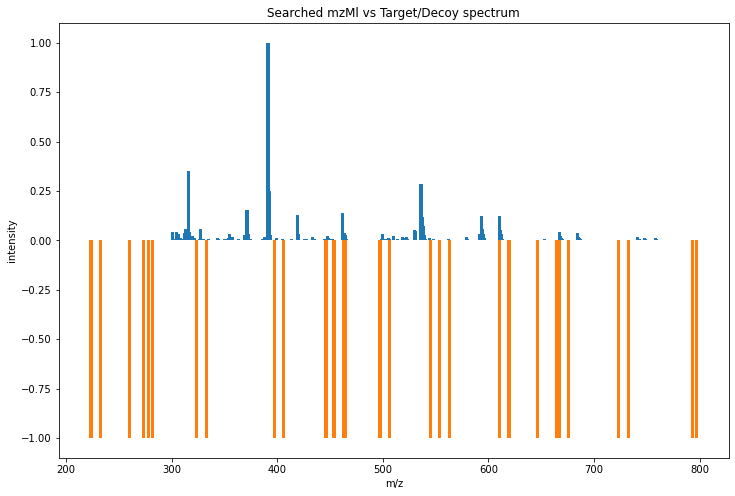

In [80]:
obs_mz, obs_int = observed_spectrum.get_peaks()


# We filter the peaks of the theoretical spectrum to fit the range (to reduce image complexity)
theo_mz, theo_int = [], []
for mz, intensity in zip(*theo_spectrum.get_peaks()):
    if mz >= 200.0 and mz <= 800.0:
        theo_mz.append(mz)
        theo_int.append(intensity)

title = 'Searched mzMl vs Target/Decoy spectrum'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

In [81]:
alignment = []
spa = SpectrumAlignment()
p = spa.getParameters()
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")
spa.setParameters(p)
# align both spectra
spa.getSpectrumAlignment(alignment, theo_spectrum, observed_spectrum)

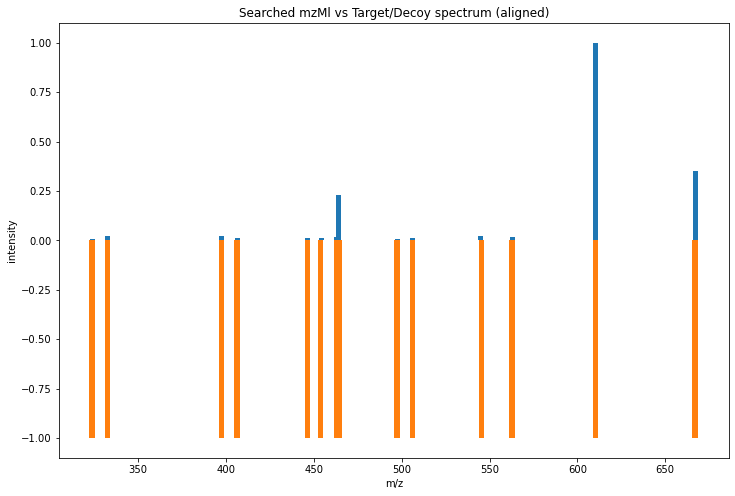

In [82]:
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for theo_idx, obs_idx in alignment:
    theo_mz.append(theo_spectrum[theo_idx].getMZ())
    theo_int.append(theo_spectrum[theo_idx].getIntensity())
    obs_mz.append(observed_spectrum[obs_idx].getMZ())
    obs_int.append(observed_spectrum[obs_idx].getIntensity())

title = 'Searched mzMl vs Target/Decoy spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

## Only Target alignment vs Searched mzMl

In [83]:
# generate target sequenes
t_sequences =''
#targets list generated at the second cell of the code
for entry in targets:
    t_sequences+=entry.sequence
    
print(t_sequences)

MKWVTFISLLLLFSSAYSRGVFRRDTHKSEIAHRFKDLGEEHFKGLVLIAFSQYLQQCPFDEHVKLVNELTEFAKTCVADESHAGCEKSLHTLFGDELCKVASLRETYGDMADCCEKQEPERNECFLSHKDDSPDLPKLKPDPNTLCDEFKADEKKFWGKYLYEIARRHPYFYAPELLYYANKYNGVFQECCQAEDKGACLLPKIETMREKVLASSARQRLRCASIQKFGERALKAWSVARLSQKFPKAEFVEVTKLVTDLTKVHKECCHGDLLECADDRADLAKYICDNQDTISSKLKECCDKPLLEKSHCIAEVEKDAIPENLPPLTADFAEDKDVCKNYQEAKDAFLGSFLYEYSRRHPEYAVSVLLRLAKEYEATLEECCAKDDPHACYSTVFDKLKHLVDEPQNLIKQNCDQFEKLGEYGFQNALIVRYTRKVPQVSTPTLVEVSRSLGKVGTRCCTKPESERMPCTEDYLSLILNRLCVLHEKTPVSEKVTKCCTESLVNRRPCFSALTPDETYVPKAFDEKLFTFHADICTLPDTEKQIKKQTALVELLKHKPKATEEQLKTVMENFVAFVDKCCAADDKEACFAVEGPKLVVSTQTALA


In [84]:
# generate target only sequenes as the (theortical) spectrum

tsg = TheoreticalSpectrumGenerator()
theo_spectrum = MSSpectrum()
p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")
p.setValue("add_metainfo", "true")
tsg.setParameters(p)


peptide = AASequence.fromString(t_sequences)
tsg.getSpectrum(theo_spectrum, peptide, 1, 2)

print(type(peptide))

<class 'pyopenms.pyopenms_1.AASequence'>


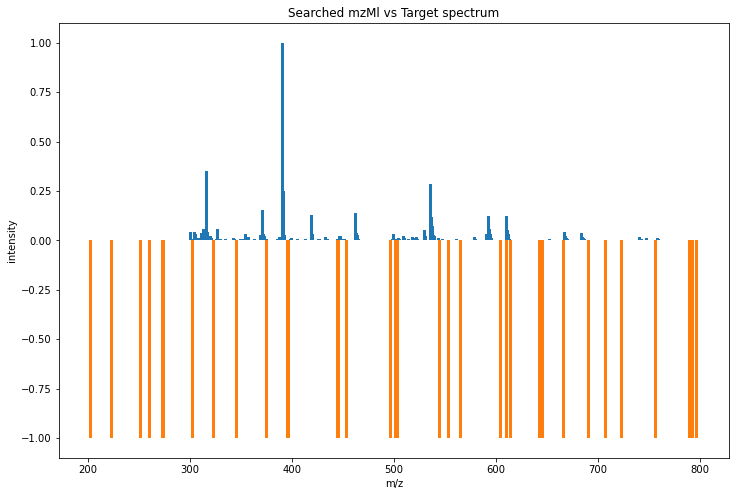

In [85]:
obs_mz, obs_int = observed_spectrum.get_peaks()


# We filter the peaks of the theoretical spectrum to fit the range (to reduce image complexity)
theo_mz, theo_int = [], []
for mz, intensity in zip(*theo_spectrum.get_peaks()):
    if mz >= 200.0 and mz <= 800.0:
        theo_mz.append(mz)
        theo_int.append(intensity)

title = 'Searched mzMl vs Target spectrum'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

In [86]:
alignment = []
spa = SpectrumAlignment()
p = spa.getParameters()
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")
spa.setParameters(p)
# align both spectra
spa.getSpectrumAlignment(alignment, theo_spectrum, observed_spectrum)

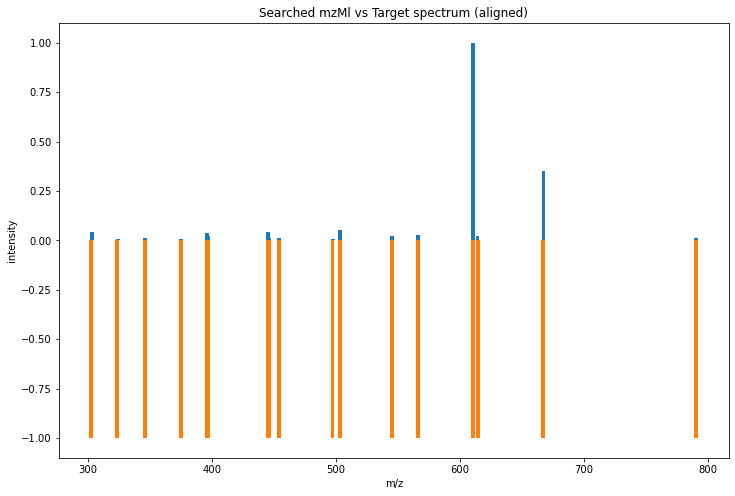

In [87]:
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for theo_idx, obs_idx in alignment:
    theo_mz.append(theo_spectrum[theo_idx].getMZ())
    theo_int.append(theo_spectrum[theo_idx].getIntensity())
    obs_mz.append(observed_spectrum[obs_idx].getMZ())
    obs_int.append(observed_spectrum[obs_idx].getIntensity())

title = 'Searched mzMl vs Target spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

## Only Decoy alignment vs Searched mzMl

In [88]:
# generate target sequenes
d_sequences =''
#decoys list generated at the second cell of the code
for entry in decoys:
    d_sequences+=entry.sequence
    
print(d_sequences)

ALATQTSVVLKPGEVAFCAEKDDAACCKDVFAVFNEMVTKLQEETAKPKHKLLEVLATQKKIQKETDPLTCIDAHFTFLKEDFAKPVYTEDPTLASFCPRRNVLSETCCKTVKESVPTKEHLVCLRNLILSLYDETCPMRESEPKTCCRTGVKGLSRSVEVLTPTSVQPVKRTYRVILANQFGYEGLKEFQDCNQKILNQPEDVLHKLKDFVTSYCAHPDDKACCEELTAEYEKALRLLVSVAYEPHRRSYEYLFSGLFADKAEQYNKCVDKDEAFDATLPPLNEPIADKEVEAICHSKELLPKDCCEKLKSSITDQNDCIYKALDARDDACELLDGHCCEKHVKTLDTVLKTVEVFEAKPFKQSLRAVSWAKLAREGFKQISACRLRQRASSALVKERMTEIKPLLCAGKDEAQCCEQFVGNYKNAYYLLEPAYFYPHRRAIEYLYKGWFKKEDAKFEDCLTNPDPKLKPLDPSDDKHSLFCENREPEQKECCDAMDGYTERLSAVKCLEDGFLTHLSKECGAHSEDAVCTKAFETLENVLKVHEDFPCQQLYQSFAILVLGKFHEEGLDKFRHAIESKHTDRRFVGRSYASSFLLLLSIFTVWKM


In [89]:
# generate target only sequenes as the (theortical) spectrum

tsg = TheoreticalSpectrumGenerator()
theo_spectrum = MSSpectrum()
p = tsg.getParameters()
p.setValue("add_y_ions", "true")
p.setValue("add_b_ions", "true")
p.setValue("add_metainfo", "true")
tsg.setParameters(p)


peptide = AASequence.fromString(d_sequences)
tsg.getSpectrum(theo_spectrum, peptide, 1, 2)

print(type(peptide))

<class 'pyopenms.pyopenms_1.AASequence'>


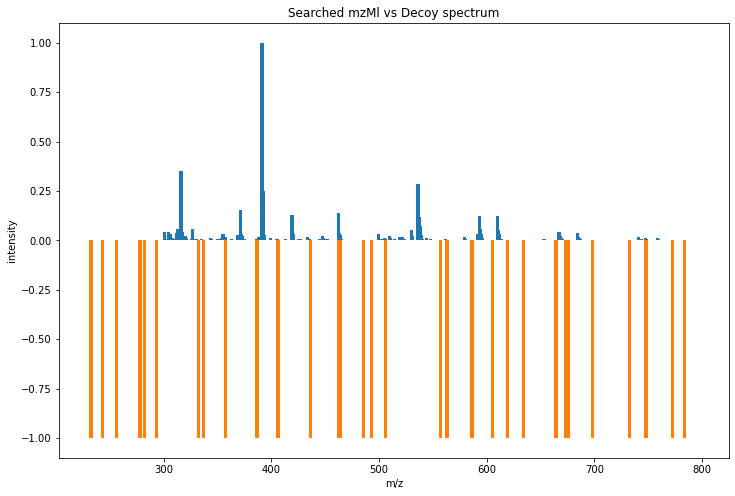

In [90]:
obs_mz, obs_int = observed_spectrum.get_peaks()


# We filter the peaks of the theoretical spectrum to fit the range (to reduce image complexity)
theo_mz, theo_int = [], []
for mz, intensity in zip(*theo_spectrum.get_peaks()):
    if mz >= 200.0 and mz <= 800.0:
        theo_mz.append(mz)
        theo_int.append(intensity)

title = 'Searched mzMl vs Decoy spectrum'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)

In [91]:
alignment = []
spa = SpectrumAlignment()
p = spa.getParameters()
p.setValue("tolerance", 0.5)
p.setValue("is_relative_tolerance", "false")
spa.setParameters(p)
# align both spectra
spa.getSpectrumAlignment(alignment, theo_spectrum, observed_spectrum)

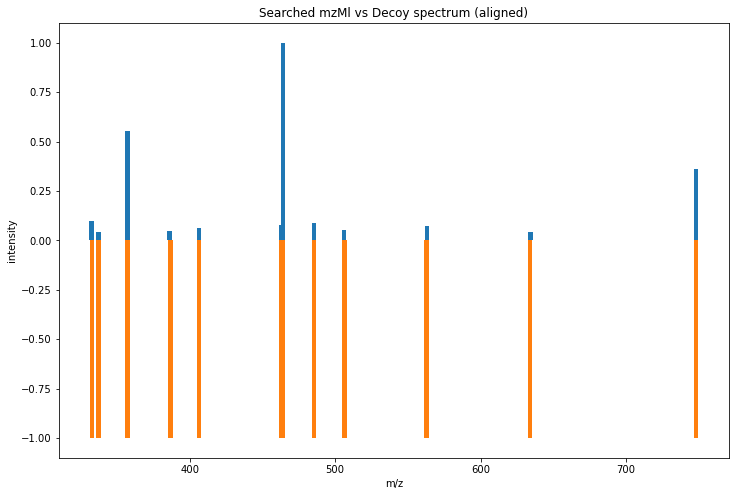

In [92]:
theo_mz, theo_int, obs_mz, obs_int = [], [], [], []
for theo_idx, obs_idx in alignment:
    theo_mz.append(theo_spectrum[theo_idx].getMZ())
    theo_int.append(theo_spectrum[theo_idx].getIntensity())
    obs_mz.append(observed_spectrum[obs_idx].getMZ())
    obs_int.append(observed_spectrum[obs_idx].getIntensity())

title = 'Searched mzMl vs Decoy spectrum (aligned)'
mirror_plot(obs_mz, obs_int, theo_mz, theo_int, title)